<strong><b><font size="5">Web Scraping e Análise de Dados</font></b></strong>

<strong><b><font size="5">Lab 2</font></b></strong>

<strong><b><font size="4">Web Scraping e Análise Estatística - Avaliando o Desempenho dos Participantes em Corridas de 10 KM com Dados de Sensores RFID</font></b></strong>

## Definição do Problema

Neste Lab vamos coletar dados reais de participantes de uma corrida de 10 KM realizada em Hillsboro no Oregon, EUA, em junho de 2017. 

O objetivo desta análise é encontrar:
    
- O tempo médio de conclusão da corrida.
- Se os tempos de chegada dos corredores seguem uma distribuição normal.
- Analisar se há diferença de desempenho entre homens e mulheres de várias faixas etárias.

Os tempos registrados na corrida (bem como outros dados) são bem precisos pois os participantes usaram sensores RFID de onde os dados foram extraídos e disponibilizados na web. Mais detalhes sobre o uso dos sensores RFID aqui:

https://www.hubertiming.com/runners/faq

## Fonte de Dados

Como fonte de dados usaremos o web site <a href="https://www.hubertiming.com/">Huber Timing</a> que contém o resultado das corridas que acontecem nos EUA, bem como a agenda de novos eventos.

Aqui a página com o resultado da corrida que faremos a análise:

https://www.hubertiming.com/results/2017GPTR10K

## Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.7


In [2]:
# Usaremos o pacote Pingouin para algumas das análises estatísticas
# https://pingouin-stats.org/index.html
!pip install -q pingouin

In [103]:
# Imports
import re
import requests
import matplotlib as m
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Imports para formatação dos gráficos
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

seaborn   : 0.11.2
pingouin  : 0.5.1
re        : 2.2.1
pandas    : 1.2.4
numpy     : 1.20.3
matplotlib: 3.4.3
requests  : 2.26.0
scipy     : 1.7.1



## Web Scraping

In [5]:
# Definindo o URL com o resultado da corrida
url = 'https://www.hubertiming.com/results/2017GPTR10K'

In [6]:
# Abre a conexão com o url
html = urlopen(url)

In [7]:
# Extrai o código html
soup = bs(html, 'lxml')

In [8]:
# Extrai o texto do código html
texto = soup.get_text()

In [9]:
# Vamos visualizar as 10 primeiras linhas
linhas = soup.find_all('tr')
print((linhas[:10]))

[<tr colspan="2">
<b>10K:</b>
</tr>, <tr>
<td>Finishers:</td>
<td>577</td>
</tr>, <tr>
<td>Male:</td>
<td>414</td>
</tr>, <tr>
<td>Female:</td>
<td>163</td>
</tr>, <tr class="header">
<th>Place</th>
<th>Bib</th>
<th>Name</th>
<th>Gender</th>
<th>City</th>
<th>State</th>
<th>Chip Time</th>
<th>Gun Time</th>
<th>Team</th>
</tr>, <tr data-bib="814">
<td>1</td>
<td>814</td>
<td>

                    JARED WILSON

                </td>
<td>M</td>
<td>TIGARD</td>
<td>OR</td>
<td>36:21</td>
<td>36:24</td>
<td></td>
</tr>, <tr data-bib="573">
<td>2</td>
<td>573</td>
<td>

                    NATHAN A SUSTERSIC

                </td>
<td>M</td>
<td>PORTLAND</td>
<td>OR</td>
<td>36:42</td>
<td>36:45</td>
<td>
<img class="lazy teamThumbs" data-src="/teamLogoThumbnail/logo?teamName=INTEL%20TEAM%20F&amp;raceId=1251&amp;state=OR"/>
                            INTEL TEAM F
                        </td>
</tr>, <tr data-bib="687">
<td>3</td>
<td>687</td>
<td>

                    FRANCISCO MAYA

      

## Limpeza e Transformação

Começaremos obtendo todas as linhas da tabela em forma de lista e depois converteremos essa lista em um dataframe para facilitar a manipulação.

In [10]:
# Loop
for linha in linhas:
    linha_td = linha.find_all('td')

In [11]:
print(linha_td)

[<td>577</td>, <td>443</td>, <td>

                    LIBBY B MITCHELL

                </td>, <td>F</td>, <td>HILLSBORO</td>, <td>OR</td>, <td>1:41:18</td>, <td>1:42:10</td>, <td></td>]


Com expressões regulares em Python, vamos extrair os dados das tags HTML.

In [12]:
# Lista vazia para receber as linhas
lista_linhas = []

In [13]:
# Loop
for linha in linhas:
    cells = linha.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '', str_cells))
    lista_linhas.append(clean2)

In [14]:
print(clean2)

[577, 443, 

                    LIBBY B MITCHELL

                , F, HILLSBORO, OR, 1:41:18, 1:42:10, ]


Convertemos a lista num dataframe e obtemos uma visão rápida das 10 primeiras linhas usando o Pandas.

In [15]:
# Convertemos a lista em dataframe
df = pd.DataFrame(lista_linhas)

In [16]:
df.head(10)

,0
0,[]
1,"[Finishers:, 577]"
2,"[Male:, 414]"
3,"[Female:, 163]"
4,[]
5,"[1, 814, \r\n\r\n JARED WIL..."
6,"[2, 573, \r\n\r\n NATHAN A ..."
7,"[3, 687, \r\n\r\n FRANCISCO..."
8,"[4, 623, \r\n\r\n PAUL MORR..."
9,"[5, 569, \r\n\r\n DEREK G O..."


Claramente precisamos limpar os dados.

In [17]:
# Dividindo cada linha e separar os dados a cada vírgula
df1 = df[0].str.split(',', expand= True)

In [18]:
df1.head(10)

,0,1,2,3,4,5,6,7,8
0,[],None,None,None,None,None,None,None,None
1,[Finishers:,577],None,None,None,None,None,None,None
2,[Male:,414],None,None,None,None,None,None,None
3,[Female:,163],None,None,None,None,None,None,None
4,[],None,None,None,None,None,None,None,None
5,[1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,]
6,[2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,[3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,]
8,[4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,]
9,[5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,39:24,\n\r\n INTEL TEAM ...


Vamos fazer mais algumas limpezas. 

In [19]:
# Removemos colchetes de abertura (lado esquerdo) do texto
df1[0] = df1[0].str.strip('[')

In [20]:
df1.head(10)

,0,1,2,3,4,5,6,7,8
0,],None,None,None,None,None,None,None,None
1,Finishers:,577],None,None,None,None,None,None,None
2,Male:,414],None,None,None,None,None,None,None
3,Female:,163],None,None,None,None,None,None,None
4,],None,None,None,None,None,None,None,None
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,]
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,]
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,]
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,39:24,\n\r\n INTEL TEAM ...


In [21]:
# Extraimos o cabeçalho de todas as tabelas no código HTML
col_labels = soup.find_all('th')

In [22]:
col_labels

[<th>Place</th>,
 <th>Bib</th>,
 <th>Name</th>,
 <th>Gender</th>,
 <th>City</th>,
 <th>State</th>,
 <th>Chip Time</th>,
 <th>Gun Time</th>,
 <th>Team</th>]

In [23]:
# Extraimos texto entre tags html dos cabeçalhos de tabela (extraimos o nome)
all_header = []
col_str = str(col_labels)
cleantext2 = bs(col_str, 'lxml').get_text()
all_header.append(cleantext2)

In [24]:
print(all_header)

['[Place, Bib, Name, Gender, City, State, Chip Time, Gun Time, Team]']


In [25]:
# Convertendo a lista de cabeçalhos num dataframe 
df2 = pd.DataFrame(all_header)

In [26]:
df2.head()

,0
0,"[Place, Bib, Name, Gender, City, State, Chip T..."


In [27]:
# Dividindo a coluna '0' em várias colunas na posição de vírgula para todas as linhas
df3 = df2[0].str.split(',', expand = True)

In [28]:
df3.head()

,0,1,2,3,4,5,6,7,8
0,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]


In [29]:
# Concatenar os dois dataframes
frames = [df3, df1]
df4 = pd.concat(frames)

In [30]:
df4.head(10)

,0,1,2,3,4,5,6,7,8
0,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]
0,],None,None,None,None,None,None,None,None
1,Finishers:,577],None,None,None,None,None,None,None
2,Male:,414],None,None,None,None,None,None,None
3,Female:,163],None,None,None,None,None,None,None
4,],None,None,None,None,None,None,None,None
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,]
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,]
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,]


In [31]:
# Atribuir a primeira coluna como cabeçalho
df5 = df4.rename(columns= df4.iloc[0])

In [32]:
df5.head()

,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]
0,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]
0,],None,None,None,None,None,None,None,None
1,Finishers:,577],None,None,None,None,None,None,None
2,Male:,414],None,None,None,None,None,None,None
3,Female:,163],None,None,None,None,None,None,None


In [33]:
# Shape
df5.shape

(583, 9)

In [34]:
# Visão geral dos dados para análise
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 581
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   [Place      583 non-null    object
 1    Bib        581 non-null    object
 2    Name       578 non-null    object
 3    Gender     578 non-null    object
 4    City       578 non-null    object
 5    State      578 non-null    object
 6    Chip Time  578 non-null    object
 7    Gun Time   578 non-null    object
 8    Team]      578 non-null    object
dtypes: object(9)
memory usage: 45.5+ KB


In [35]:
# Verificar valores ausentes
df5.isnull().sum()

[Place        0
 Bib          2
 Name         5
 Gender       5
 City         5
 State        5
 Chip Time    5
 Gun Time     5
 Team]        5
dtype: int64

In [36]:
# removendo todas a linhas com valores ausentes
df6 = df5.dropna(axis= 0, how= 'any')
df6.head()

,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]
0,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,]
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,]
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,]


In [78]:
# Descartar o cabeçalho da tabela replicada como a primeira linha no df5
df7 = df6.drop(df6.index[0])
df7.head()

,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,]
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,]
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,]
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,39:24,\n\r\n INTEL TEAM ...


In [79]:
# Removendo as colunas [Place] & [Team]
df7.rename(columns= {'[Place': 'Place'}, inplace = True)
df7.rename(columns= {' Team]': 'Team'}, inplace = True)

In [80]:
# Limpeza final dos dados - remoção do colchete de fechamento das células na coluna 'Team'
df7['Team'] = df7['Team'].str.strip(']')

In [81]:
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,39:24,\n\r\n INTEL TEAM ...


## Análise de Dados

In [82]:
# Converter a coluna 'Chip Time' em minutos

# 'Chip Time' é o tempo total de corrida medido com a leitura do sensor RFID no selo da camisola do participante

time_list = df7[' Chip Time'].tolist()

In [83]:
# Visualizar uma amostra de dados
time_list[1:5]

[' 36:42', ' 37:44', ' 38:34', ' 39:21']

In [84]:
# Lista para receber o resultado da conversão
time_mins = []

In [85]:
# Loop para conversão
for i in time_list:
    i = i.strip(' ')
    if len(i)!=7:
        i = '0:' + i
    h, m, s = i.split(':')
    math = (int(h) * 3600 + int(m) * 60 + int(s))/60
    time_mins.append(math)

Convertendo a lista novamente num dataframe e cramos uma nova coluna ("Runner_mins") como tempo total da corrida, mas agora em minutos

In [86]:
# Nova coluna 
df7['Runner_mins'] = pd.Series(time_mins)

In [87]:
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team,Runner_mins
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,,39.816667
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...,40.066667
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,,40.083333
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,,40.283333
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,39:24,\n\r\n INTEL TEAM ...,40.350000


In [88]:
df7.dtypes

Place           object
 Bib            object
 Name           object
 Gender         object
 City           object
 State          object
 Chip Time      object
 Gun Time       object
Team            object
Runner_mins    float64
dtype: object

In [94]:
# Cálculo de estatistícas para colunas numéricas no dataframe
df7.describe(include= [np.number])

,Runner_mins
count,572.000000
mean,60.230828
std,11.838436
min,39.816667
25%,51.125000
50%,59.250000
75%,67.275000
max,101.300000


**Análise**:

- O tempo médio de chip para todos os corredores foi de ~ 60 minutos (a média na tabela acima).
- O corredor 10K mais rápido terminou em 39,81 minutos (valor mínimo na tabela acima).
- O corredor mais lento terminou em 101,30 minutos (valor máximo na tabela acima).

Vamos criar um boxplot para sumarizar nossa análise.

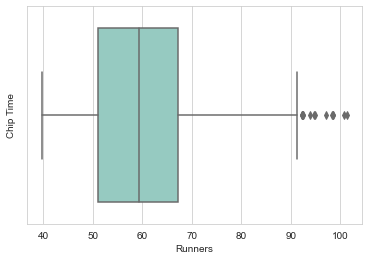

In [110]:
# Plot
ax = sns.boxplot(x = df7["Runner_mins"], palette = "Set3")
plt.ylabel('Chip Time')
plt.xlabel('Runners')
plt.show()

Criaremos agora um gráfico de distribuição dos tempos dos chips dos corredores usando a biblioteca seaborn.

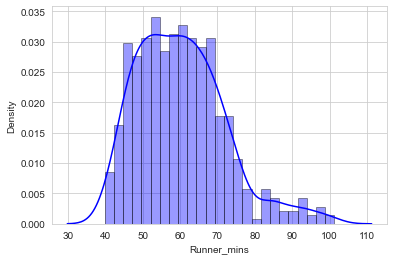

In [104]:
# Plot
x = df7['Runner_mins']
ax = sns.distplot(x, hist = True, kde = True, rug = False, color = 'blue', bins = 25, hist_kws = {'edgecolor':'black'})
plt.show()

A distribuição da variável parece quase normal. Mas vamos realizar um teste estatístico para confirmar.

O pacote stats do SciPy fornece uma função para um dos testes de normalidade mais comuns, o Shapiro-Wilk Test. Usaremos ainda a função normality do pacote Pengouin.

**A hipótese nula deste teste é que a população é normalmente distribuída. Assim, se o valor-p for menor que o nível alfa escolhido (normalmente definido em 0,05), a hipótese nula será rejeitada e há evidências de que os dados testados não são normalmente distribuídos.**

O resultado do teste de Shapiro-Wilk deve ser interpretado com cautela no caso de amostras grandes.

In [111]:
# Valor de x
x = df7['Runner_mins']

In [112]:
# Teste de normalidade com Scipy
stats.shapiro(x)

ShapiroResult(statistic=nan, pvalue=1.0)

In [113]:
# Teste de normalidade com Pingouin
pg.normality(x)

,W,pval,normal
Runner_mins,0.956769,6.547689e-12,False


**Análise**:

- A variável não segue uma distribuição normal, uma vez que o valor-p é menor que 0.05 e assim há evidências estatísticas para rejeitar a hipótese nula. A função normality() do pacote Pingouin coloca essa informação na última coluna.

Vamos agora descobrir se houve alguma diferença de desempenho entre homens e mulheres de várias faixas etárias.

In [114]:
# Separando os dados
f_runners = df7.loc[df7[' Gender'] == ' F']['Runner_mins']
m_runners = df7.loc[df7[' Gender'] == ' M']['Runner_mins']

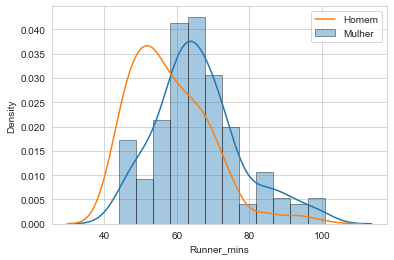

In [118]:
# Criaremos os 2 plots em uma só figura para facilitar a comparação
sns.distplot(f_runners, hist = True, kde = True, rug = False, hist_kws = {'edgecolor':'black'}, label = 'Mulher')
sns.distplot(m_runners, hist = False, kde = True, rug = False, hist_kws = {'edgecolor':'black'}, label = 'Homem')
plt.legend();

**Análise**:

- A distribuição indica que as mulheres eram mais lentas que os homens, em média.

In [119]:
# Resumo das estatísticas para homens e mulheres separadamente usando o método groupby ()
g_stats = df7.groupby(" Gender", as_index = True).describe()
g_stats

Runner_mins                                                         \
              count       mean        std        min        25%        50%   
 Gender                                                                      
 F            159.0  65.988260  11.862212  44.100000  58.908333  64.583333   
 M            413.0  58.014286  11.070460  39.816667  49.700000  56.216667   

                                
               75%         max  
 Gender                         
 F       72.016667  100.783333  
 M       64.933333  101.300000

**Análise**:
    
- O tempo médio de chip para todas as mulheres e homens foi de ~ 66 minutos e ~ 58 minutos, respectivamente, comprovando a análise do gráfico.

Um boxplot ajuda a comparar as amostras de homens e mulheres.

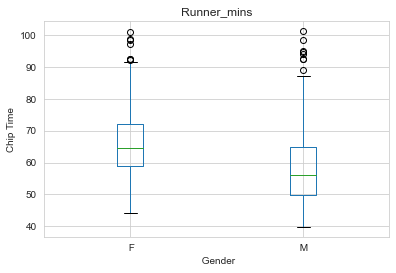

In [121]:
# Plot
df7.boxplot(column = 'Runner_mins', by = ' Gender')
plt.ylabel('Chip Time')
plt.suptitle("");

# Fim